Add Air_Prophet_Op. read Markdown

In [ ]:
import numpy as np
import pandas as pd

import optuna

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

# Plot
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

import plotly.graph_objects as go

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

In [2]:
pip install neuralprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 2.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
from neuralprophet import NeuralProphet
from statistics import mean

NeuralPorphet はとても良さそうに見えますが、実際には全自動 AR であり、私の意見では SARIMAX の Pytorch バージョンです

NeuralProphet に付属している米国の電力消費データ セットは、実際の戦闘に使用されます.データ セットは非常にシンプルで、さまざまな地域の 1 時間あたりの電力消費量が含まれています。

このデータセットは、予測が必要な変数のみが含まれており、電力消費以外は何もない、非常に優れたデータセットです。

タスクを定義します。

エリア内の電力消費を予測する
次の 24 時間の予測消費量

In [4]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"

In [5]:
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")

In [6]:
df_ercot['ds'] = pd.to_datetime(df_ercot['ds'])
df_ercot.head()

ds    COAST    EAST  FAR_WEST   NORTH  NORTH_C  SOUTHERN  \
0 2004-01-01 01:00:00  7225.09  877.79   1044.89  745.79  7124.21   1660.45   
1 2004-01-01 02:00:00  6994.25  850.75   1032.04  721.34  6854.58   1603.52   
2 2004-01-01 03:00:00  6717.42  831.63   1021.10  699.70  6639.48   1527.99   
3 2004-01-01 04:00:00  6554.27  823.56   1015.41  691.84  6492.39   1473.89   
4 2004-01-01 05:00:00  6511.19  823.38   1009.74  686.76  6452.26   1462.76   

   SOUTH_C    WEST  
0  3639.12  654.61  
1  3495.16  639.88  
2  3322.70  623.42  
3  3201.72  613.49  
4  3163.74  613.32

クイックベースライン

最初にトレーニングとテストのために NeuralProphet に付属のパラメーターを使用し、次に予測結果とエラーをプロットします。

---

データをプレビューしてみると、やはり周期性があることがわかる。このようなデータは、NeuralProphetに適しています。

もう一つのポイントは、地域によって使用量の振幅にまだ大きな差があり、800以下のところもあれば、7000のところもあることです

columns　の　ds はPlotする必要はない。

<AxesSubplot:>

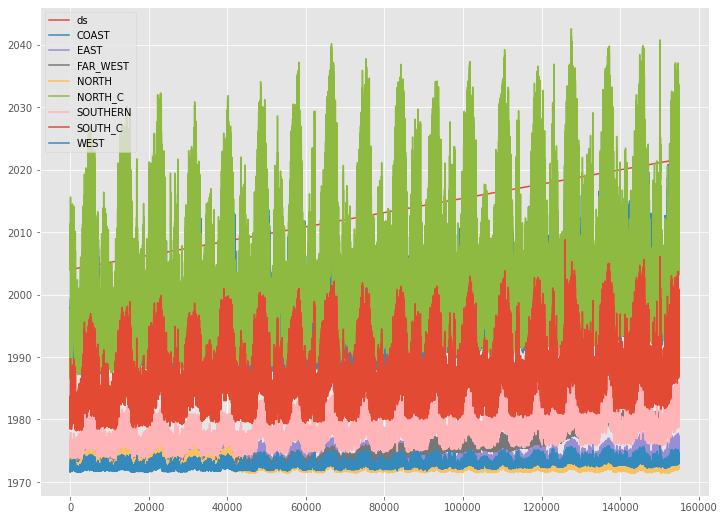

In [7]:
df_ercot.plot()

In [8]:
#regions = len(df_ercot.columns) - 1 
regions = df_ercot.columns[1:] # outside ds
regions

Index(['COAST', 'EAST', 'FAR_WEST', 'NORTH', 'NORTH_C', 'SOUTHERN', 'SOUTH_C',
       'WEST'],
      dtype='object')

NeuralProphet がデータを受け入れるには、各時系列を DataFrame に変換し、それを dict に含める必要があります。キーは時系列の名前で、値は対応する DataFrame です。

In [9]:
df_list = list()
df_dict = {}
for cols in regions:
    aux = df_ercot[['ds', cols]].copy() #select column associated with region
    aux = aux.iloc[:26301, :].copy() #selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns = {cols: 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
    df_list.append(aux)
    df_dict[cols] = aux

# シナリオ 1: すべての時系列のトレーニングと予測
COASTとEASTの過去のデータが既知であり、これら 2 つの地域のデータも将来予測されると仮定します。

デフォルトでは、NeuralProphet はグローバル モデルを有効にしているため、構築したdf_dictデータを直接入力できます。

In [10]:
m_case1 = NeuralProphet(n_lags=24, normalize='minmax')

df_train_dict, df_test_dict = m_case1.split_df(df_dict, valid_p=0.33, local_split=True)

two_df = dict((k,df_train_dict[k]) for k in ['COAST', 'EAST'])

metrics_case1 = m_case1.fit(two_df, freq='H')

WARNING - (NP.df_utils.prep_or_copy_df) - dict as input are deprecated. Please, use dataframes with ‘ID’ column instead
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H


  0%|          | 0/163 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.80E-02, min: 1.90E+00


  0%|          | 0/163 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.80E-02, min: 1.29E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.18E-02
WARNING - (NP.forecaster._train) - When Global modeling with local normalization, metrics are displayed in normalized scale.
Epoch[75/75]: 100%|██████████| 75/75 [01:43<00:00,  1.39s/it, SmoothL1Loss=0.000144, MAE=0.0127, RMSE=0.0168, Loss=0.00011, RegLoss=0] 


トレーニング後、予測予測を呼び出すことです。

予測データには、 COASTおよび EAST地域のタイムスタンプ データも含まれている必要があります。

In [11]:
two_df_test = dict((k,df_test_dict[k]) for k in ['COAST', 'EAST'])

future = m_case1.make_future_dataframe(two_df_test, n_historic_predictions = True)

forecast_two_df_case1 = m_case1.predict(future)

WARNING - (NP.df_utils.prep_or_copy_df) - dict as input are deprecated. Please, use dataframes with ‘ID’ column instead
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning dict
WARNING - (NP.df_utils.prep_or_copy_df) - dict as input are deprecated. Please, use dataframes with ‘ID’ column instead
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined

その後、予測結果をプロットします。

**現在、プロット関数は更新されておらず、単一の時系列をプロットした予測結果のみをサポートしていることに注意してください。**

**したがって、ここでは、予測のすべての結果を直接描画できる関数を定義しました。**

主にグローバル モデルの使用方法を説明します。予測の効果についてはここでは説明しません。

In [12]:
def plot_forecast_dict(forecast_dict):
    fig = go.Figure()
    for col in forecast_dict:
        fig.add_trace(go.Scatter(mode='markers',x = forecast_dict[col]['ds'],y=forecast_dict[col]['y'],name=f'{col}_y',opacity=0.5,marker=dict(size=2)))
        fig.add_trace(go.Scatter(mode='lines',x = forecast_dict[col]['ds'],y=forecast_dict[col]['yhat1'],name=f'{col}_y_hat'))

    return fig

fig = plot_forecast_dict(forecast_two_df_case1)
fig.show()

# シナリオ 2: すべての時系列をトレーニングするが、一部の時系列を予測する
予測の際、時系列の一部のみを入力することもできます.たとえば、ここではCOAST時系列のみを予測します.

この場合、モデルを再トレーニングする必要はありません。データを予測するときにCOAST時系列を提供するだけで済みます。

トレーニング データは dict であるため、予測データも dict 形式である必要があることを強調しておく必要があります。

In [13]:
one_df_test = dict((k,df_test_dict[k]) for k in ['COAST'])
forecast_one_df_case1 = m_case1.predict(one_df_test)

fig = plot_forecast_dict(forecast_one_df_case1)
fig.show()

WARNING - (NP.df_utils.prep_or_copy_df) - dict as input are deprecated. Please, use dataframes with ‘ID’ column instead
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning dict


# シナリオ 3: いくつかの時系列をトレーニングし、すべての時系列を予測する (コールド スタートの問題) 
コールドスタートの問題はどうですか？つまり、トレーニングデータにはこの時系列はありませんが、予測するときはこの時系列を予測したいと考えています。

たとえば、 COAST と EASTの履歴データしかありませんが、 NORTHエリアの消費データを予測したいとします。

ここで、unknown_data_normalization を True に設定する必要があります。

これにより、NeuralProphet はローカル パラメータがあるかどうかを自動的にチェックし、ない場合はグローバル パラメータを使用します。

In [14]:
m_case2 = NeuralProphet(n_lags = 24,normalize='minmax',unknown_data_normalization =True)

two_df = dict((k,df_train_dict[k]) for k in ['COAST', 'EAST'])

metrics_case2 = m_case2.fit(two_df, freq = 'H')

two_df_test = dict((k,df_test_dict[k]) for k in ['COAST', 'NORTH'])

future = m_case2.make_future_dataframe(two_df_test, n_historic_predictions = True)

forecast_two_df_case2 = m_case2.predict(future)

fig = plot_forecast_dict(forecast_two_df_case2)
fig.show()

WARNING - (NP.df_utils.prep_or_copy_df) - dict as input are deprecated. Please, use dataframes with ‘ID’ column instead
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.994% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.994% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 75


  0%|          | 0/163 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.80E-02, min: 1.29E+00


  0%|          | 0/163 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.80E-02, min: 7.74E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.18E-02
WARNING - (NP.forecaster._train) - When Global modeling with local normalization, metrics are displayed in normalized scale.
Epoch[75/75]: 100%|██████████| 75/75 [01:49<00:00,  1.46s/it, SmoothL1Loss=0.000144, MAE=0.0127, RMSE=0.0168, Loss=0.00011, RegLoss=0] 
WARNING - (NP.df_utils.prep_or_copy_df) - dict as input are deprecated. Please, use dataframes with ‘ID’ column instead
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning dict

Prophet は、本質的に時系列をトレンド条件、季節サイクル、離散時間イベント、および外部リグレッサーに分解するシグナル分解のアイデアに基づいています。

・トレンド項は区分線形であり、一般的な信号分解の線形性と比較すると、革新的であり、落とし穴です。トレンド用語は好転するとサイクルと衝突しやすく（オーバーフィッティング）、ここが一番オーバーフィッティングしやすい部分だと感じています。

・フーリエ級数を特定の周波数（周期）に調整できる周期項も、精度を向上させる革新的なポイントです。

・離散時間イベントと外部リグレッサーも外部共変量を追加できますが、線形ではありますが、何もないよりはましです。

**Neural Prophet は Relu 非線形化を使用**



# NeuralProphet 2

<AxesSubplot:xlabel='ds'>

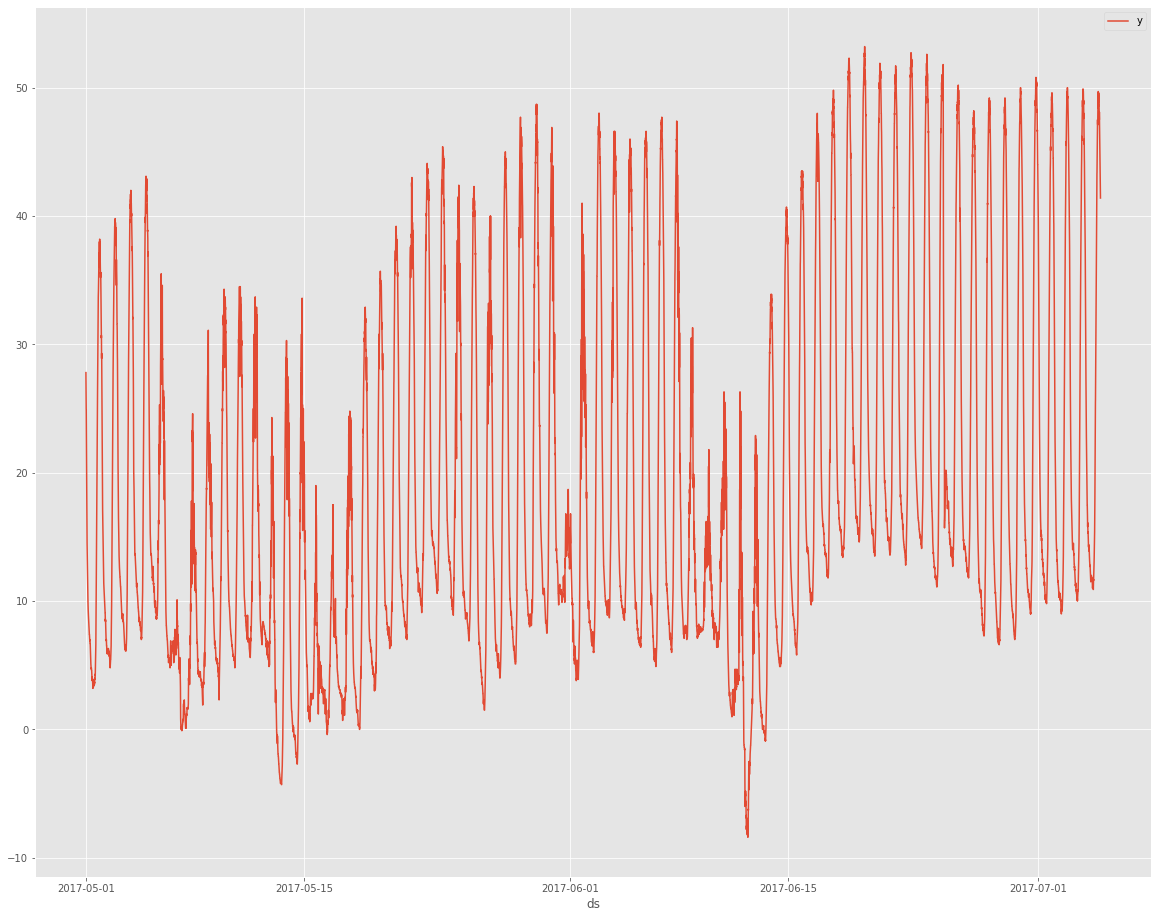

In [30]:
from neuralprophet import NeuralProphet

import seaborn as sns

data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df = pd.read_csv(data_location + "yosemite_temps.csv")
df['ds'] = pd.to_datetime(df['ds'])
plt.figure(figsize=(20,16))
sns.lineplot(data = df.set_index('ds'))

In [16]:
m_baseline = NeuralProphet()
df_train, df_test = m_baseline.split_df(df, freq='5min', valid_p = 0.20)
plt.figure(figsize=(20,16))
metrics = m_baseline.fit(df_train, freq='5min',validation_df=df_test) # plot_live_loss=True 

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 93


  0%|          | 0/154 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.08E-02, min: 1.50E+00


  0%|          | 0/154 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.82E-02, min: 1.50E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.66E-02
  0%|          | 0/93 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:921: UserWarning:

Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:921: UserWarning:

Using a target size (torch.Size([672])) that is different to the input size (torch.Size([672, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch[93/93]: 100%|██████████| 93/93 [00:52<00:00,  1.77it/s, SmoothL1Loss=0.00611, MAE=4.12, RMSE=5.71, Loss=0.00488, Re

<Figure size 1440x1152 with 0 Axes>

plot_parameters を見ることができます。最初のコンポーネントはトレンド アイテムです。

この振幅レベル (30+) を見て、株価のトレンドがこのようなものである場合、急上昇しているテール トレンドを見る

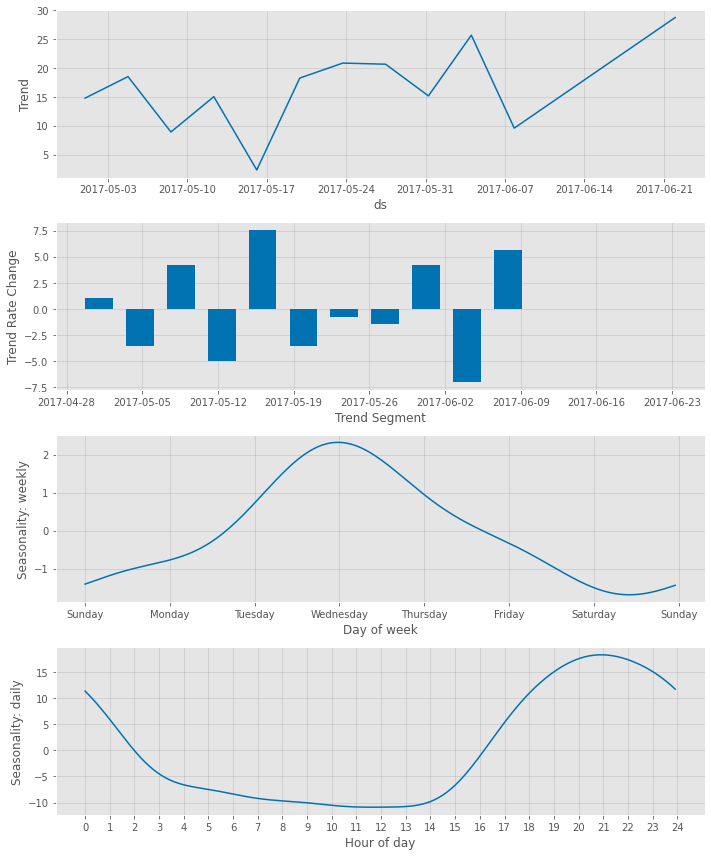

In [17]:
fig_param = m_baseline.plot_parameters()

In [18]:
metrics.columns

Index(['SmoothL1Loss', 'MAE', 'RMSE', 'Loss', 'RegLoss', 'SmoothL1Loss_val',
       'MAE_val', 'RMSE_val'],
      dtype='object')

<AxesSubplot:>

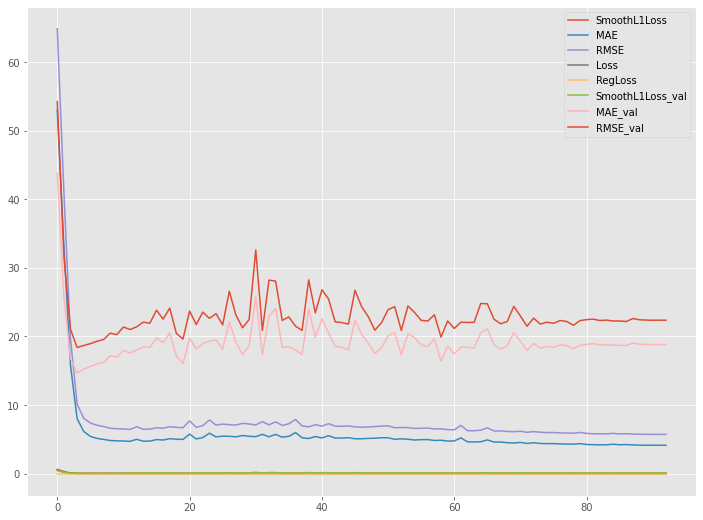

In [19]:
metrics.plot()

In [20]:
metrics.RMSE_val.head(-1)

0     54.219875
1     31.689133
2     21.032645
3     18.382850
4     18.664749
        ...    
87    22.604647
88    22.416534
89    22.375664
90    22.348986
91    22.360484
Name: RMSE_val, Length: 92, dtype: float64

In [21]:
metrics.SmoothL1Loss, metrics.SmoothL1Loss_val

(0     0.614039
 1     0.292782
 2     0.075735
 3     0.019466
 4     0.012105
         ...   
 88    0.006159
 89    0.006133
 90    0.006130
 91    0.006113
 92    0.006109
 Name: SmoothL1Loss, Length: 93, dtype: float64,
 0     0.457405
 1     0.181552
 2     0.081538
 3     0.062284
 4     0.064334
         ...   
 88    0.094678
 89    0.094293
 90    0.094093
 91    0.094190
 92    0.094114
 Name: SmoothL1Loss_val, Length: 93, dtype: float64)

<AxesSubplot:>

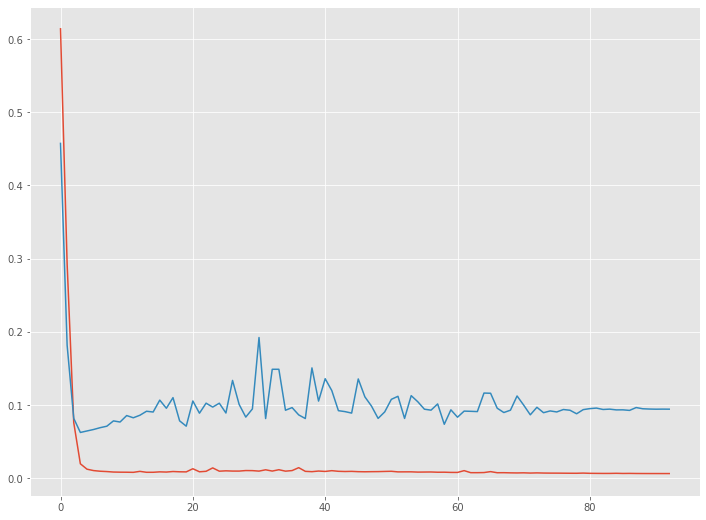

In [22]:
metrics.SmoothL1Loss.plot()
metrics.SmoothL1Loss_val.plot()

In [24]:
m_future = m_baseline.make_future_dataframe(df_train, n_historic_predictions=True)

df_pred = m_baseline.predict(m_future)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


# Neural Prophet の別の見方

AR の出現は、このバグを埋め、モデルをより堅牢にすることです。 



ARは過去のデータを使って未来のデータを予測するものだからです。直感的に言えば、これがベースラインです。ベースラインがあると、それがどれほど悪いかまだ心配ですか?



このデータ セットの解像度は 5 分で、温度は通常の 1 日サイクルです。そのため、自己回帰パラメーターとして 1 日のデータを使用します。

同じコードですが、AR モデルを開始します。

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 93


  0%|          | 0/154 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.58E-03, min: 3.38E-01


  0%|          | 0/154 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.96E-03, min: 3.38E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.14E-03
Epoch[93/93]: 100%|██████████| 93/93 [00:58<00:00,  1.59it/s, SmoothL1Loss=0.000121, MAE=0.484, RMSE=0.79, Loss=8.78e-5, RegLoss=0, MAE_val=16, RMSE_val=20.7, SmoothL1Loss_val=0.0789]    


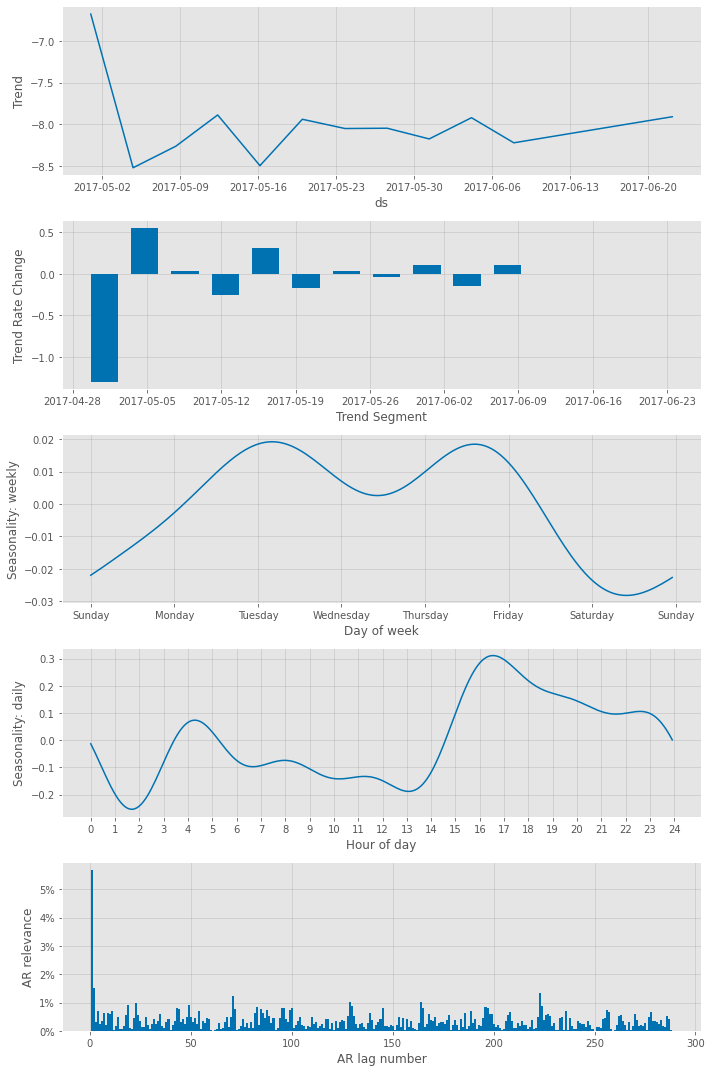

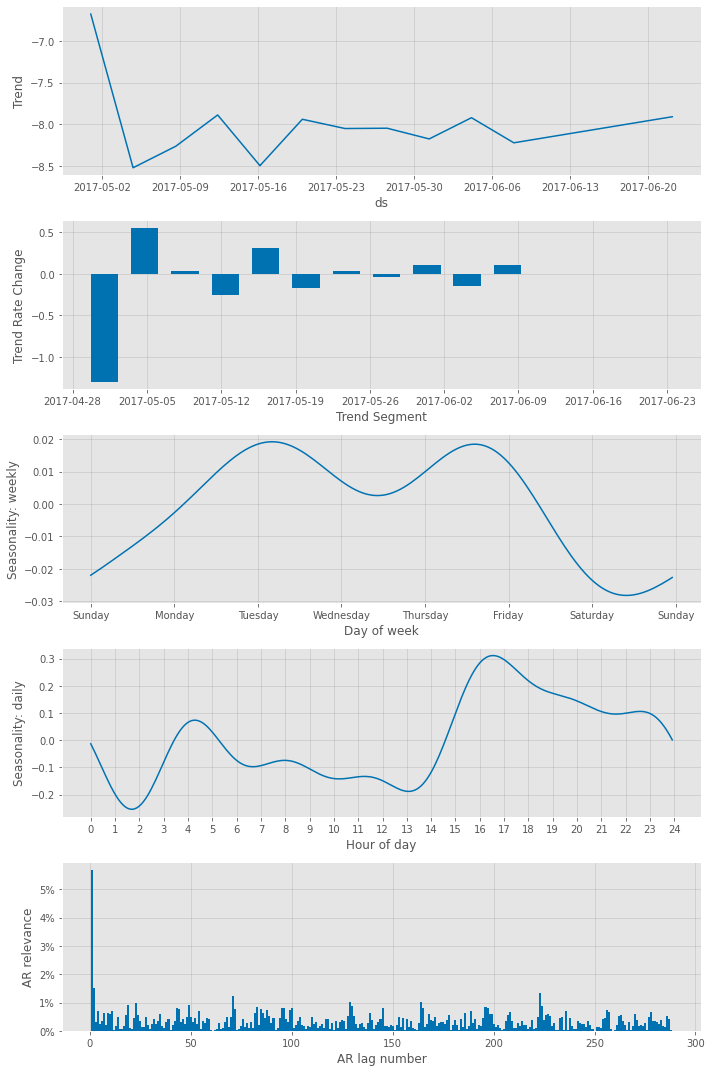

In [31]:
m_add_lag = NeuralProphet(n_lags=12*24)
df_train, df_test = m_add_lag.split_df(df, freq='5min', valid_p = 0.20)
m_add_lag.fit(df_train, freq='5min',validation_df=df_test)
m_add_lag.plot_parameters()

# NeuralProphet Optuna

In [4]:
pip install loguru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 846.4 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
set_random_seed(10)

import optuna
from copy import deepcopy
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

from loguru import logger

from datetime import datetime
now = datetime.now().strftime("%m_%d_%Y_%H")
logger.add(f"neuralprophet_optuna_{now}.log")

1

In [6]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")

df_ercot['ds'] = pd.to_datetime(df_ercot['ds'])
df_ercot.head()

ds    COAST    EAST  FAR_WEST   NORTH  NORTH_C  SOUTHERN  \
0 2004-01-01 01:00:00  7225.09  877.79   1044.89  745.79  7124.21   1660.45   
1 2004-01-01 02:00:00  6994.25  850.75   1032.04  721.34  6854.58   1603.52   
2 2004-01-01 03:00:00  6717.42  831.63   1021.10  699.70  6639.48   1527.99   
3 2004-01-01 04:00:00  6554.27  823.56   1015.41  691.84  6492.39   1473.89   
4 2004-01-01 05:00:00  6511.19  823.38   1009.74  686.76  6452.26   1462.76   

   SOUTH_C    WEST  
0  3639.12  654.61  
1  3495.16  639.88  
2  3322.70  623.42  
3  3201.72  613.49  
4  3163.74  613.32

In [7]:
ts = df_ercot[['ds', 'COAST']].copy() #select column associated with region :リージョンに関連する選択カラム
ts = ts.iloc[:26301, :].copy() #selects data up to 26301 row (2004 to 2007 time stamps) :  26301行（2004年～2007年のタイムスタンプ）までのデータを選択します。
ts = ts.rename(columns = {'COAST': 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet : Neural Prophetと互換性のあるように、データ列の名前を'y'に変更する。

# Baseline
デフォルトのベースラインを基準にしてモデルの性能がどの程度上がっているのかを確認する指標にする

In [8]:
n_lags = 24
n_forecasts= 24*1
m = NeuralProphet(n_lags = n_lags,n_forecasts= n_forecasts, normalize='minmax')
ts_train, ts_test = m.split_df(ts, valid_p = 0.2, local_split = True)
metrics = m.fit(ts_train)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.forecaster.__handle_missing_data) - 3 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 3 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 3 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_e

  0%|          | 0/158 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.03E-02, min: 2.18E+00


  0%|          | 0/158 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.03E-02, min: 1.12E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.64E-02
Epoch[85/85]: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it, SmoothL1Loss=0.00129, MAE=401, RMSE=544, Loss=0.000981, RegLoss=0]    


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


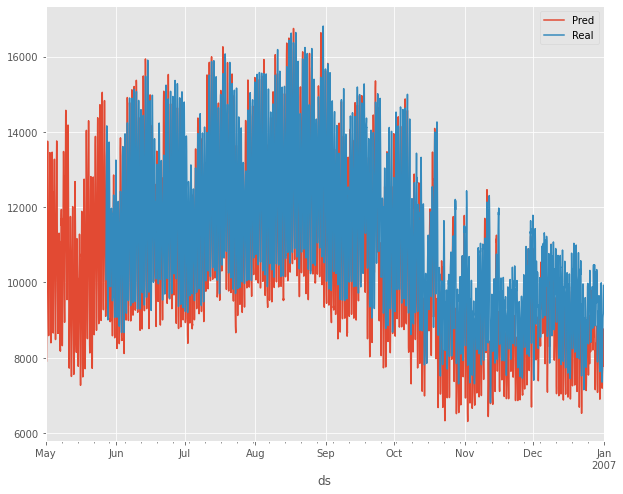

In [9]:
forecast_test = m.predict(ts_test)
fig,ax = plt.subplots(figsize=(10,8))
ts.set_index('ds').loc['2006-05':,'y'].plot(ax=ax,label='Pred')
forecast_test.set_index('ds').loc['2006-05':,'yhat24'].plot(ax=ax,label='Real')
ax.legend()

In [10]:
last_day = 60
print(f'mean_absolute_percentage_error for last {last_day} days is:')
print(mean_absolute_percentage_error(ts.set_index('ds')['y'].iloc[-24*last_day:], forecast_test.set_index('ds')['yhat24'].iloc[-24*last_day:]))

mean_absolute_percentage_error for last 60 days is:
0.10556894057323186


# **Optuna**

前述の手順に従って、最初にパラメーターの検索範囲を定義します。ここでは、各ハイパーパラメーターの検索範囲を含む境界変数を定義

注意点は次の3点です。

・各パラメーターは異なる方法でサンプリングされる場合があります (nph_warper 関数)

    ・たとえば changepoints_range の場合、0.88888 のようなパラメータは好きではないので、手動でリストを指定して optuna サンプラーに抽出させます
    
    ・trend_reg、検索空間は 0.001 から 1 で、ここでは対数レベル抽出法が使用されます

・すでにいくつかのハイパーパラメータを決定して default_para に保存しているので、後は Optuna の更新辞書だけが必要です。

・定義した検索空間は、NeuralProphet 関数だけでなく、add_seasonality 関数にも使用されるため、さまざまな関数を個別に渡します。

In [18]:
default_para = dict(n_lags=n_lags, n_forecasts=n_forecasts, changepoints_range=0.8, n_changepoints=5, trend_reg=0.1, normalize='minmax', learning_rate =1)

param_types = dict(changepoints_range='float',n_changepoints='int',trend_reg='float',learning_rate='float',month_order = 'int',week_order ='int')
bounds = {'changepoints_range': [0.6,0.8,0.9],
          'n_changepoints': [4, 8],
          'trend_reg': [0.001, 1],
          'learning_rate': [0.001, 1],
          'month_order': [3, 8],
          'week_order': [2, 5],
         }


def create_nph(**para):
    temp_para = deepcopy(para)
    month_order = temp_para.pop('month_order')
    week_order = temp_para.pop('week_order')
    m = NeuralProphet(**temp_para)
    m = m.add_seasonality('my_month', 28, month_order)
    m = m.add_seasonality('my_week', 7, week_order)
    return m

def nph_warper(trial,ts):
    params = {}
    params['changepoints_range'] = trial.suggest_categorical('changepoints_range', bounds['changepoints_range'])
    params['n_changepoints'] = trial.suggest_int('n_changepoints', bounds['n_changepoints'][0], bounds['n_changepoints'][1])
    params['trend_reg'] = trial.suggest_float('trend_reg', bounds['trend_reg'][0], bounds['trend_reg'][1]) # suggest_float
    params['learning_rate'] = trial.suggest_float('learning_rate', bounds['learning_rate'][0], bounds['learning_rate'][1]) # suggest_float
    params['month_order'] = trial.suggest_int('month_order', bounds['month_order'][0], bounds['month_order'][1])
    params['week_order'] = trial.suggest_int('week_order', bounds['week_order'][0], bounds['week_order'][1])
    temp_para = deepcopy(default_para)
    temp_para.update(params)
    logger.info('*********************************')
    logger.info(temp_para)
    METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']
    metrics_test = pd.DataFrame(columns=METRICS)
    m = create_nph(**temp_para)
    folds = m.crossvalidation_split_df(ts, freq="H", k=5, fold_pct=0.2, fold_overlap_pct=0.5)
    for df_train, df_test in folds:
        m = create_nph(**temp_para)
        train = m.fit(df_train)
        test = m.test(df=df_test)
        metrics_test = metrics_test.append(test[METRICS].iloc[-1])
    out = metrics_test['MAE'].mean()
    logger.info(out)
    return out

探索空間を定義したら、次のステップは目的関数 (目的関数) を定義することです。

この目的関数では、特定の時系列について、nph_warper が optuna が推奨するハイパーパラメータで最小の MAE を取得することを期待しています。

In [19]:
def objective(trial):
    '''
    【1】リージョンに関連する選択カラム
    【2】26301行（2004年～2007年のタイムスタンプ）までのデータを選択します。
    【3】Neural Prophetと互換性のあるように、データ列の名前を'y'に変更する。
    '''
    ts = df_ercot[['ds', 'COAST']].copy() #select column associated with region【１】
    ts = ts.iloc[:26301, :].copy() #selects data up to 26301 row (2004 to 2007 time stamps)【２】
    ts = ts.rename(columns = {'COAST': 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet【３】
    return nph_warper(trial,ts)

# **並列処理**
Optuna のチューニングはすでに非常に効率的ですが、変数が多い場合は依然として時間がかかります。

この時点で、並列処理を開始できます.並列処理の原理は非常に単純で、実験結果を共有することです.

結果を任意のデータベースに保存して、どのコンピュータまたはプログラムを実行したかに関係なく、どのような実験が行われたか、次にどのように検索するかを知ることができます。

ここで同じコンピューター上で、sqlite を使用してテスト結果を保存し、create_study を最初のスクリプトに使用できます

### **optuna.load_study()**
後続 (2 番目、n 番目) の並列スクリプトには、load_study のみが必要です。

In [21]:
study = optuna.create_study(direction='minimize',study_name='nph_tuning', storage="sqlite:///nph.db")
study.optimize(objective, n_trials=5)

#study = optuna.create_study(direction='minimize',study_name='nph_tuning') # 1度実行していた場合、その実行を止めると　storageがある場合動かないのでこれを使用する。
#study.optimize(objective, n_trials=5)

# study = optuna.load_study(study_name='nph_tuning', storage="sqlite:///nph.db")
# study.optimize(objective, n_trials=5)

[I 2022-10-30 07:28:46,004] A new study created in memory with name: nph_tuning
2022-10-30 07:28:46.016 | INFO     | __main__:nph_warper:32 - *********************************
2022-10-30 07:28:46.017 | INFO     | __main__:nph_warper:33 - {'n_lags': 24, 'n_forecasts': 24, 'changepoints_range': 0.6, 'n_changepoints': 4, 'trend_reg': 0.13786203888389187, 'normalize': 'minmax', 'learning_rate': 0.8145639619472407, 'month_order': 6, 'week_order': 3}
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.forecaster.__handle_missing_data) - 3 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 3 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 3 NaN values in column y were auto-imputed.
INFO - (NP.

In [22]:
study.best_trial

FrozenTrial(number=2, values=[446.9653662463067], datetime_start=datetime.datetime(2022, 10, 30, 7, 43, 4, 119291), datetime_complete=datetime.datetime(2022, 10, 30, 7, 49, 58, 803954), params={'changepoints_range': 0.8, 'n_changepoints': 4, 'trend_reg': 0.8168683620226223, 'learning_rate': 0.6536736374259605, 'month_order': 4, 'week_order': 2}, distributions={'changepoints_range': CategoricalDistribution(choices=(0.6, 0.8, 0.9)), 'n_changepoints': IntDistribution(high=8, log=False, low=4, step=1), 'trend_reg': FloatDistribution(high=1.0, log=False, low=0.001, step=None), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.001, step=None), 'month_order': IntDistribution(high=8, log=False, low=3, step=1), 'week_order': IntDistribution(high=5, log=False, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None)

In [23]:
study.best_params

{'changepoints_range': 0.8,
 'n_changepoints': 4,
 'trend_reg': 0.8168683620226223,
 'learning_rate': 0.6536736374259605,
 'month_order': 4,
 'week_order': 2}

{'changepoints_range': 0.6,
 'learning_rate': 0.08063369045454732,
 'month_order': 5,
 'n_changepoints': 4,
 'trend_reg': 0.9973229886042836,
 'week_order': 5}

In [24]:
best_para = deepcopy(default_para)
best_para.update(study.best_params)

m_best = create_nph(**best_para)
ts_train, ts_test = m_best.split_df(ts, valid_p = 0.2, local_split = True)
after_metrics = m_best.fit(ts_train)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.forecaster.__handle_missing_data) - 3 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 3 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 3 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.995% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


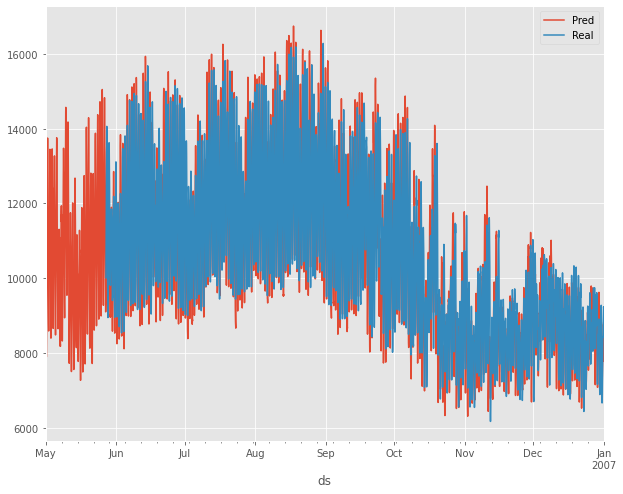

In [25]:
after_forecast_test = m_best.predict(ts_test)
after_forecast_test
fig,ax = plt.subplots(figsize=(10,8))
ts.set_index('ds').loc['2006-05':,'y'].plot(ax=ax,label='Pred')
after_forecast_test.set_index('ds').loc['2006-05':,'yhat24'].plot(ax=ax,label='Real')
ax.legend()

In [26]:
print(f'mean_absolute_percentage_error for last {last_day} days is:')
print(mean_absolute_percentage_error(ts.set_index('ds')['y'].iloc[-24*last_day:], after_forecast_test.set_index('ds')['yhat24'].iloc[-24*last_day:]))

mean_absolute_percentage_error for last 60 days is:
0.05507999938529654


# **パラメータ調整結果の可視化**


さらに、Optuna は、チューニング プロセス中に何が起こっているのかを理解するのに役立つさまざまな視覚化を提供します。

たとえば、どのハイパーパラメータを選択したかがより重要か、plot_param_importances で確認できます。

In [27]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(
    width=1000,
    height=500   
)
fig.show()

または、調整パラメーターの履歴を表示します: plot_optimization_history

In [28]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(
    width=1000,
    height=500   
)
fig.show()

または、多次元パラメーターのグラフを参照してください: plot_parallel_coordinate

In [29]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(
    width=1000,
    height=500   
)
fig.show()

In [30]:
df_list = list()
df_dict = {}
for cols in regions:
    aux = df_ercot[['ds', cols]].copy() #select column associated with region
    aux = aux.iloc[:26301, :].copy() #selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns = {cols: 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
    df_list.append(aux)
    df_dict[cols] = aux

NameError: name 'regions' is not defined

In [ ]:
m_case1 = NeuralProphet(n_lags=24, normalize='minmax')

df_train_dict, df_test_dict = m_case1.split_df(df_dict, valid_p=0.33, local_split=True)

two_df = dict((k,df_train_dict[k]) for k in ['COAST', 'EAST'])

metrics_case1 = m_case1.fit(two_df, freq='H')

In [ ]:
two_df_test = dict((k,df_test_dict[k]) for k in ['COAST', 'EAST'])

future = m_case1.make_future_dataframe(two_df_test, n_historic_predictions = True)

forecast_two_df_case1 = m_case1.predict(future)